# Detecting Illegal Fishing in Real Time
##### Analysis by Geetak Ingle
Skills: 
- Data Wrangling and Cleaning
- Exploratory Data Analysis
- Supervised and Semi-Supervised Learning
    - Support Vector Machines, Gradient Boosted Trees, Random Forest
    - Pseudo-Labeling
- Bias-Variance Tradeoff Management


## Table of Contents

1. Problem Statement
2. Data Wrangling
3. Exploratory Data Analysis
4. Evaluation and Final Results
5. Conclusions and Next Steps
6. References

## 1) Problem Statement

The global seafood market was about US$113.2 billion in 2020 and is expected to continue increasing every year [1]. To capitalize on this market, bad actors employ slave labor and engage in illegal, unreported, and unregulated (IUU) fishing to generate revenue. These acts are blatant violations of human rights and result in ocean exploitation. Furthermore, IUU fishing is detrimental to the long-term sustainability of the fishing industry. It undermines the efforts of fishers that employ legal and ethical means of fishing, threatens vulnerable populations of sea life, and contributes to declining ocean health [2].

The inherent problem for regulatory bodies/authorities is that IUU fishing is hard to detect and prosecute since there is little to no governance of human activities on the vast open ocean. The Automated Identification System (AIS) can be turned off or spoofed by IUU fishing vessels, making it hard to manually track their movements. Furthermore, vessels engaged in IUU fishing are able operate far from their home port and stay out on the ocean for long periods of time by using transshipments [3] – the practice of rendezvousing with resupply vessels (such as refrigerator carriers to transfer catch, tankers, etc.) – making it harder for authorities to enforce the law. To further exacerbate the problem, port authorities lack the capacity to thoroughly inspect every vessel that docks/anchors in port.

Transshipment events provide an opportunity to detect IUU events. While IUU ships tend to be smaller ships that may operate dark (AIS turned off), transshipment vessels (resupply vessels that enable transshipments to IUU vessels) are larger vessels rarely go fully dark since they are under different regulations [3]. By observing movement patterns of transshipment vessels and determining when these ships maintain idle speed and heading, far away from the shore (loitering event) – such as when transferring illegal catch from IUU vessels – it may be possible to detect the presence of IUU fishing activities with a high degree of certainty in real-time. By doing so, the appropriate regulatory bodies, patrol boats, and other enforcement agencies will be able to proactively intercept the vessels to obtain evidence of fishing and human right transgressions and pursue appropriate prosecution. This will improve the ocean health, lead to sustainable fishing populations, as well as increasing sustainable fishing practices.

This objective of this analysis is to develop an anomaly detection model that detect IUU (illegal, unreported, unregulated) activities using loitering events on any given trip for any given vessel. The analysis will also discover the characteristics of loitering events of transshipment vessels that engage in IUU activities. Once the model has been deployed, the data obtained from active investigations must be used to improve the model performance.

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Set seed
np.random.seed(31415926) 

## 2) Data Wrangling

The Global Fishing Watch (GFW) is a non-profit organization that has gathered and analyzed a vast amount of GPS and AIS data to enable scientific research and drive oversight for human activities in the ocean. They also validate this data from first-hand eyewitness data as well as detailed journalism. All data required for the purposes of the proposed analysis in this report will be obtained from their managed databases, following their Terms of Use.

In [2]:
# Load all data required for analysis
# Data includes 
#   - Loitering Events for Carrier and Bunker classed ships
#   - GFW's model output for classifying ships engaged in slave labor
df_fishing_vessels = pd.read_csv("data/fishing-vessels-v2.csv")
df_loiter_carrier = pd.read_csv("data/carrier_loitering_v20210408.csv")
df_loiter_bunker = pd.read_csv("data/bunker_loitering_v20210408.csv")
df_model_raw = pd.read_csv("data/s1_training_final.csv")
df_model_labels = pd.read_csv("data/s4_final_model_predictions.csv")


In [3]:
# Cleanup data and merge different DataFrames to get the final required dataset
merge_on = ["hours","fishing_hours","average_daily_fishing_hours","fishing_hours_foreign_eez","fishing_hours_high_seas","distance_traveled_km"]
df_model = pd.merge(df_model_raw[merge_on + ["mmsi"]],df_model_labels, on=merge_on, how="right" )
# https://stackoverflow.com/questions/15222754/groupby-pandas-dataframe-and-select-most-common-value
df_grouped_mmsi = df_model.groupby("mmsi")["Prediction"].apply(pd.Series.mode).reset_index()#.agg(pd.Series.mode).reset_index()
df_grouped_mmsi = df_grouped_mmsi.drop_duplicates(subset=['mmsi'], keep="last")
df_loiter_data_carrier = pd.merge(df_grouped_mmsi[["mmsi","Prediction"]], df_loiter_carrier, left_on="mmsi", right_on="carrier_mmsi", how="right")
df_loiter_data_bunker = pd.merge(df_grouped_mmsi[["mmsi","Prediction"]], df_loiter_bunker, left_on="mmsi", right_on="bunker_mmsi", how="right")
df_loiter_data = pd.concat([df_loiter_data_carrier,df_loiter_data_bunker])

## Define Class Labeling and encode classes to chosen definitions
IUU_LABEL = 0
NON_IUU_LABEL = 1
UNLABELLED = -1
# Get loiter start hour of day feature. This feature can be useful
df_loiter_data['loitering_start_timestamp'] = pd.to_datetime(df_loiter_data['loitering_start_timestamp'], infer_datetime_format=True)
df_loiter_data['loitering_start_hour'] = df_loiter_data['loitering_start_timestamp'].dt.hour
df_loiter_data['response'] = df_loiter_data['Prediction'].apply(lambda x: IUU_LABEL if x == 'Positive' else (NON_IUU_LABEL if x == 'Negative' else UNLABELLED))
df_loiter_data_unlabeled = df_loiter_data[df_loiter_data['response'] == UNLABELLED].reset_index(drop=True)
df_loiter_data_labeled = df_loiter_data[df_loiter_data['response'] != UNLABELLED].reset_index(drop=True)

# Remove outliers
outliers_labeled = [987]
df_loiter_data_labeled.drop(index=outliers_labeled, inplace=True)

# Extract Relevant columns
rel_cols = ['response','loitering_start_hour','loitering_hours','avg_speed_knots','avg_distance_from_shore_nm']
df_raw_all = df_loiter_data[rel_cols]
df_raw_labeled = df_loiter_data_labeled[rel_cols]
df_raw_unlabeled = df_loiter_data_unlabeled[rel_cols]

## 3) Exploratory Data Analysis

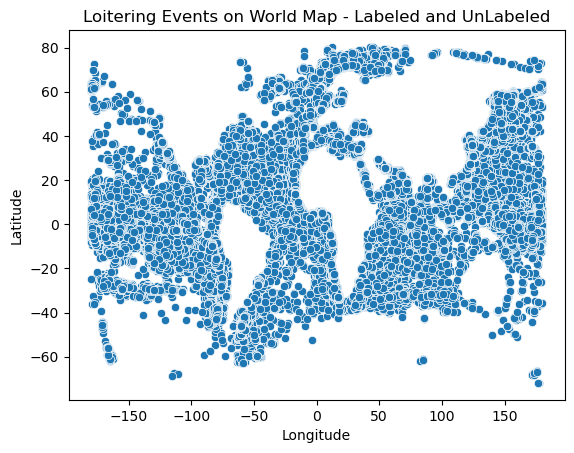

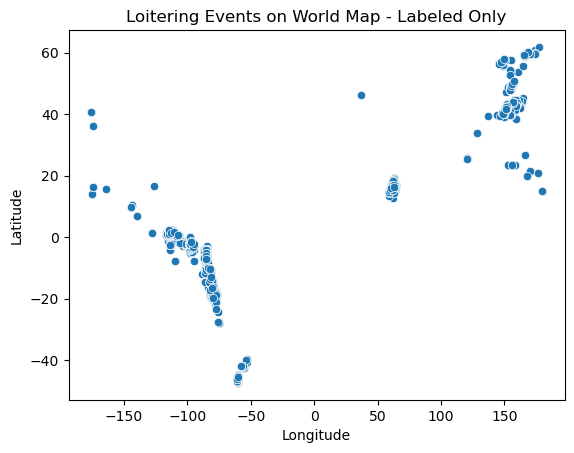

In [4]:
## See locations of all loitering events using latitude and longitude
# ALL DATAPOINTS
ax2 = sns.scatterplot(data=df_loiter_data, x="mean_lon",y="mean_lat")
ax2.set(title="Loitering Events on World Map - Labeled and UnLabeled", xlabel="Longitude", ylabel="Latitude")
plt.show()
# LABELED DATA ONLY
ax1 = sns.scatterplot(data=df_loiter_data_labeled, x="mean_lon",y="mean_lat")
ax1.set(title="Loitering Events on World Map - Labeled Only", xlabel="Longitude", ylabel="Latitude")
plt.show()

From the charts above, the labeled events are severely underrepresented as compared to the overall event dataset. Therefore, any use of spatial coordinate features in training of the Anomaly Detection Model will result in incorrect outputs; these features will not be used.

The Correlation Heatmap for all the figures is shown below. Discounting the spatial coordinate features, *tot_distance_nm* has collinearity with *loitering_hours*. This is valid as the distance a ship travels is directly proportional to how long it loiters for (assuming non-zero speed captured by *avg_speed_knots*). Therefore, *tot_distance_nm* can be removed since *avg_speed_knots* and *loitering_hours* capture all the information provided by *tot_distance_nm*.

C:\Users\Geetak\AppData\Local\Temp\ipykernel_20700\1612396860.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_loiter_data.corr()


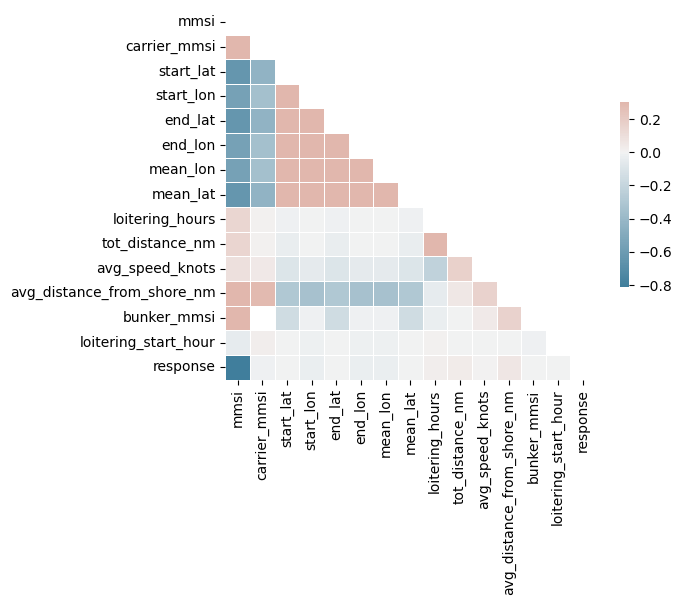

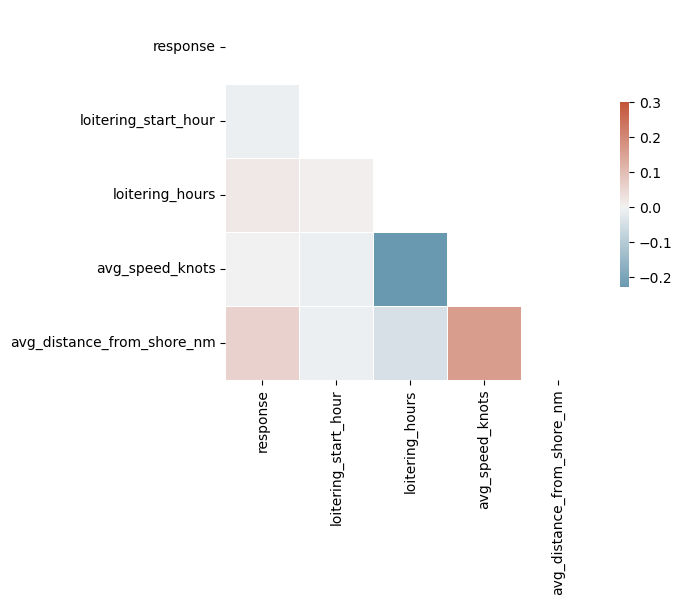

In [5]:
# Correlation Matrix for all Features
corr = df_loiter_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Correlation Matrix for filtered features
corr = df_raw_all.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

PCA can be used to visualize the features into two dimensions to gain insights on linear separability of the data. Plotting PC1 and PC2 from the PCA analysis shows that a linear decision boundary can exist between the two classes

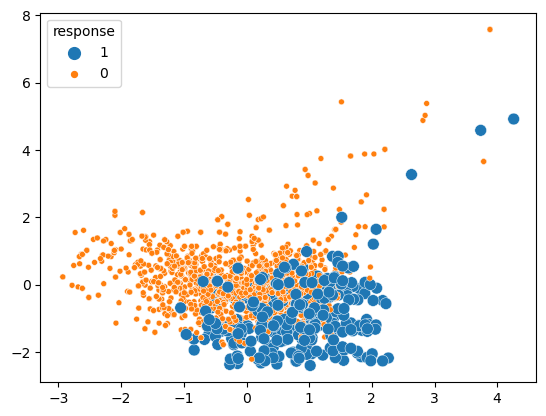

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split

# First Scale Data
scaler = StandardScaler()
df_raw_all_scaled = scaler.fit_transform(df_raw_all.drop(columns='response'))
df_raw_labeled_scaled = scaler.fit_transform(df_raw_labeled.drop(columns='response'))
df_raw_unlabeled_scaled = scaler.fit_transform(df_raw_unlabeled.drop(columns='response'))

# Get Train/Test datasets
X_train = df_raw_labeled_scaled
y_train = df_loiter_data_labeled['response']
X_test = df_raw_all_scaled
y_test = df_loiter_data['response']

# Perform PCA
pca = PCA(3, whiten=True)
PCs = pca.fit(X_train).transform(X_train)
PC1,PC2,PC3 = np.split(PCs, 3, 1)
sns.scatterplot(x=PC1.ravel(), y=PC2.ravel(), hue=y_train.astype(str), size=y_train.astype(str))
plt.show()

## 4) Evaluation and Final Results

Five supervised models will be trained using the labeled data:
- Logistic Regression
- Gaussian Mixture Model
- SVM
- Decision Tree
- Random Forest 

For an imbalanced dataset, Saito and Rehmsmeier [4] found that using Precision-Recall (PR) curves over ROC curves provide a better representation of the classification. Due to one class dominating the other, the accuracy can remain artificially high for varying models, making comparisons hard. Using PR instead can alleviate this issue as it can be used to focus on the under-represented class.

Therefore, model selection will be based on maximizing of the Macro $F_2$ score:
$$ F_{2} = 5* \left[ \frac{Precision * Recall}{4*Precision + Recall} \right]$$ 

In [7]:
# Import required packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM

In [8]:
# Perform Train/Test Splits
scaler = StandardScaler()
df_raw_all_scaled = scaler.fit_transform(df_raw_all.drop(columns='response'))
df_raw_labeled_scaled = scaler.fit_transform(df_raw_labeled.drop(columns='response'))
df_raw_unlabeled_scaled = scaler.fit_transform(df_raw_unlabeled.drop(columns='response'))

df_raw_all_labels = df_raw_all['response']
df_raw_labeled_labels = df_raw_labeled['response']

X_train, X_test, y_train, y_test = train_test_split(df_raw_labeled_scaled, df_raw_labeled_labels, test_size=0.2)

In [9]:
# Setup F-beta scorer
from sklearn.metrics import make_scorer, fbeta_score

BETA = 2.0
fbeta_scorer = make_scorer(fbeta_score, beta=BETA)

Logistic Regression

In [10]:
# Train Model - Implement GridseachCV and perform Hyperparameter Tuning
logreg = LogisticRegression(penalty='l2')
params = {'C':list(np.arange(0.001, 10, 0.1)),'class_weight':[None, 'balanced']}
gcv = GridSearchCV(logreg, param_grid=params, scoring=fbeta_scorer)
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

best_model = gcv.best_estimator_
display(best_model)
y_pred = best_model.predict(X_test)
print(f"Bal. Accuracy - Train Set: {balanced_accuracy_score(y_train,best_model.predict(X_train))}")
print(f"Bal. Accuracy - Test Set: {balanced_accuracy_score(y_test,best_model.predict(X_test))}")
print("Confusion Matrix:")
display(confusion_matrix(y_test, y_pred))
print("Classification Report")
print(classification_report(y_test, best_model.predict(X_test)))

LogisticRegression(C=9.701, class_weight='balanced')

Bal. Accuracy - Train Set: 0.8917216828478964
Bal. Accuracy - Test Set: 0.8894093216428242
Confusion Matrix:


array([[357,  37],
       [  7,  48]], dtype=int64)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       394
           1       0.56      0.87      0.69        55

    accuracy                           0.90       449
   macro avg       0.77      0.89      0.81       449
weighted avg       0.93      0.90      0.91       449



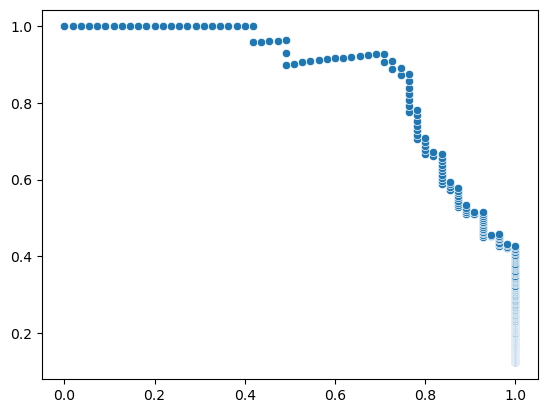

0.6716083955987922

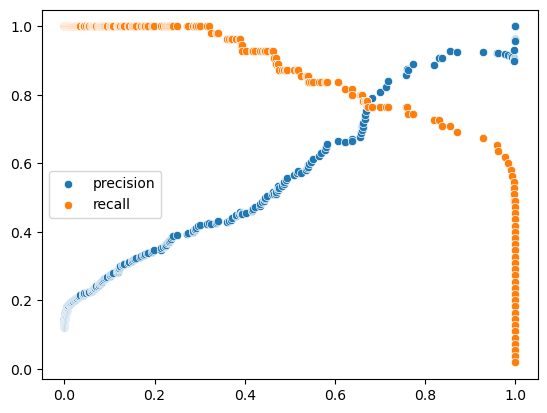

In [11]:
# Example plot
precision, recall, thresholds = precision_recall_curve(y_test,best_model.predict_proba(X_test)[:,1])
sns.scatterplot(x=recall, y=precision)
plt.show()
idx = np.argmin(np.abs(precision-recall))
display(thresholds[idx])
sns.scatterplot(x=thresholds, y=precision[:-1], label='precision')
sns.scatterplot(x=thresholds, y=recall[:-1], label='recall')
plt.show()

Gaussian Mixture Model

In [12]:
gmm = GaussianMixture(n_components=2, covariance_type='full', init_params='random')
gmm.fit(X_train)
y_pred = gmm.predict(X_test)
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.6636971046770601


array([[295,  99],
       [ 52,   3]], dtype=int64)

SVM

In [13]:
params = {'C': np.arange(0.0005, 0.01, 0.005),
          'class_weight': [None, 'balanced'],
          'kernel': ['linear', 'rbf'],
        }
svm = SVC(probability=True)
gcv = GridSearchCV(svm, param_grid=params, scoring='balanced_accuracy')
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

svm_best = gcv.best_estimator_ # Get best model
# Get train and test error
print(f"Bal. Accuracy - Train Set: {balanced_accuracy_score(y_train,svm_best.predict(X_train))}")
print(f"Bal. Accuracy - Test Set: {balanced_accuracy_score(y_test,svm_best.predict(X_test))}")
print("Confusion Matrix:")
display(confusion_matrix(y_test, svm_best.predict(X_test)))
print("Classification Report")
print(classification_report(y_test, svm_best.predict(X_test)))

Bal. Accuracy - Train Set: 0.8631326860841424
Bal. Accuracy - Test Set: 0.8934240886017535
Confusion Matrix:


array([[353,  41],
       [  6,  49]], dtype=int64)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       394
           1       0.54      0.89      0.68        55

    accuracy                           0.90       449
   macro avg       0.76      0.89      0.81       449
weighted avg       0.93      0.90      0.91       449



Decision Tree

In [14]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': list(range(2,20)),
          'min_samples_split': list(range(2,30)),
        }
cart = DecisionTreeClassifier()
gcv = GridSearchCV(cart, param_grid=params, scoring=fbeta_scorer)
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

cart_best = gcv.best_estimator_ # Get best model
cart_best.fit(X_train, y_train)  # Train best model
#visualize = plot_tree(cart_best)

# Get train and test error
cart_best.score(X_test, y_test)
y_pred = cart_best.predict(X_test)
display(confusion_matrix(y_test, y_pred))

array([[388,   6],
       [ 14,  41]], dtype=int64)

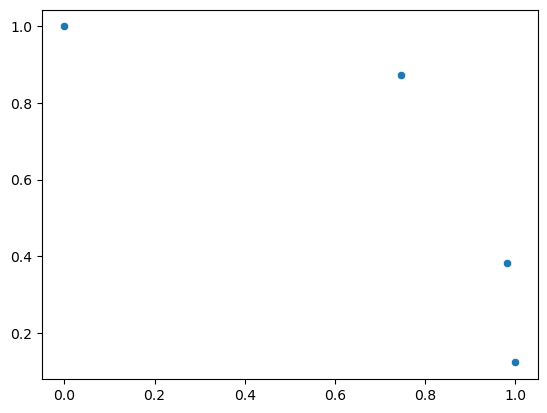

0.9285714285714286

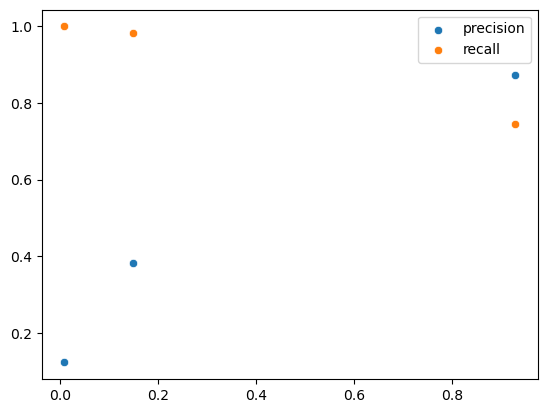

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test,cart_best.predict_proba(X_test)[:,1])
sns.scatterplot(x=recall, y=precision)
plt.show()
idx = np.argmin(np.abs(precision-recall))
display(thresholds[idx])
sns.scatterplot(x=thresholds, y=precision[:-1], label='precision')
sns.scatterplot(x=thresholds, y=recall[:-1], label='recall')
plt.show()

Random Forest

In [16]:
params = {'n_estimators': list(range(1,100))
        }
rf = RandomForestClassifier(max_depth=5, 
                            criterion='entropy', 
                            class_weight='balanced')
gcv = GridSearchCV(rf, param_grid=params, scoring=fbeta_scorer)
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

rf_best = gcv.best_estimator_ # Get best model
rf_best.fit(X_train, y_train)  # Train best model
#visualize = plot_tree(rf_best)

# Get train and test error
rf_best.score(X_test, y_test)
y_pred = rf_best.predict(X_test)
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, rf_best.predict(X_test)))

array([[365,  29],
       [ 11,  44]], dtype=int64)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       394
           1       0.60      0.80      0.69        55

    accuracy                           0.91       449
   macro avg       0.79      0.86      0.82       449
weighted avg       0.93      0.91      0.92       449



Since the **Random Forest** provided the best F2 score, this model is chosen to conduct the semi-supervised learning on the unlabeled data


In [17]:
# Pickle Scaler
with open("scaler",'wb') as file:
    pickle.dump(scaler,file)

# Pickle RandomForest Model that was chosen
with open("model",'wb') as file:
    pickle.dump(rf_best,file)

#### SEMI-SUPERVISED LEARNING: PSEUDO-LABELING
The inference model will be a One-Class Support Vector Machine (OCSVM) to be used in anomaly detection. The semi-supervised model will be an input to this training model.

The following methodology is followed to generate pseduo labels:
1. Start with a trained supervised classification model for the labeled dataset
2. Predict the binary classification probabilities for all samples in the unlabeled dataset.
3. For each class in the prediction, if the classification probability is greater than the threshold of 80%, the probability is one-hot encoded into the appropriate sample label, which are now pseudo-labels. The threshold is set high to only allow labels with high confidence to be converted, but not too high to restrict new pseudo-labels
4. Remove the newly labeled datapoints from the unlabeled dataset
5. Re-train the model from Step 1 with all labeled and pseudo-labeled points
6. Repeat steps 2-5 until no additional pseudo-labels are identified
7. Use the testing dataset to determine the performance of the classification model training on all the pseudo-labels

Using the Pseudo-Labeling, generate additional labeled dataset can be generated, but following high confidence predictions from the true labeled dataset. This ensures the complete dataset is utilized to train the OCSVM, as well as reducing OCSVM variance by adding bias through Pseudo-Labeling. The trained OCSVM model’s performance will be assessed using the testing dataset. 

In [18]:
# Pickle scaler
with open("scaler",'wb') as file:
    pickle.dump(scaler,file)

In [19]:
# Setup CV
MAX_DEPTH = 9
THRESHOLD = 0.8
ITERATIONS = 20
BETA = 2.0

# Setup F-beta scorer
fbeta_scorer = make_scorer(fbeta_score, beta=BETA)

# Setup splits
X_train, X_test, y_train, y_test = train_test_split(df_raw_labeled_scaled, df_raw_labeled_labels, test_size=0.2)


params = {'n_estimators': list(range(1,100))}
rf = RandomForestClassifier(max_depth=MAX_DEPTH, 
                            criterion='entropy', 
                            class_weight='balanced')
gcv = GridSearchCV(rf, param_grid=params, scoring=fbeta_scorer)
gcv.fit(X_train, y_train)

rf_best = gcv.best_estimator_ # Get best model

# Get train and test error
rf_best.score(X_test, y_test)
y_pred = rf_best.predict(X_test)
print("---- Supervised Training ----")
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, rf_best.predict(X_test)))

with open("Sup_model_train",'wb') as file:
    pickle.dump(rf_best,file)

# Prepare data
training_features = X_train.copy()
training_labels = y_train.copy()
unlabeled_features = df_raw_unlabeled_scaled.copy()

# Import trained supervised model
with open("Sup_model_train",'rb') as file:
    model = pickle.load(file)

# Run SSL 
for i in range(ITERATIONS):

    # Predict probabilities of unlabeled set
    pred = model.predict_proba(unlabeled_features)[:,1]
    
    # Get indexes of pseudo-labels that meet the threshold
    idxs = np.where((pred > THRESHOLD) | (pred < 1-THRESHOLD))[0]
    
    # Append features
    training_features = np.concatenate([training_features,df_raw_unlabeled_scaled[idxs]])
    
    # Append pseudo-labels
    training_labels = np.concatenate([training_labels, pred[idxs].round(0).astype(int)]) 
    
    # Remove idxs from unlabeled sets
    remove_idxs = np.where(~((pred > THRESHOLD) | (pred < 1-THRESHOLD)))[0]
    unlabeled_features = unlabeled_features[remove_idxs]
    
    # Retrain model
    model.fit(training_features,training_labels)
    
    # Break conditions
    if(len(unlabeled_features) < 50 or len(idxs) == 0):
        break

with open("SSL_final_model",'wb') as file:
    pickle.dump(model,file)

with open("SSL_final_labels",'wb') as file:
    pickle.dump(np.concatenate([training_features, training_labels[:,None]], axis=1),file)

print("---- SSL Training Error ----")
display(confusion_matrix(training_labels,model.predict(training_features)))
print(classification_report(training_labels, model.predict(training_features)))


print("---- SSL Test Error ----")
display(confusion_matrix(y_test,model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

---- Supervised Training ----


array([[378,  10],
       [ 16,  45]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       388
           1       0.82      0.74      0.78        61

    accuracy                           0.94       449
   macro avg       0.89      0.86      0.87       449
weighted avg       0.94      0.94      0.94       449

---- SSL Training Error ----


array([[131646,   8950],
       [ 19151,  27985]], dtype=int64)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90    140596
           1       0.76      0.59      0.67     47136

    accuracy                           0.85    187732
   macro avg       0.82      0.77      0.78    187732
weighted avg       0.84      0.85      0.84    187732

---- SSL Test Error ----


array([[366,  22],
       [ 11,  50]], dtype=int64)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       388
           1       0.69      0.82      0.75        61

    accuracy                           0.93       449
   macro avg       0.83      0.88      0.85       449
weighted avg       0.93      0.93      0.93       449



#### TRAIN ANOMALY DETECTION MODEL (OCSVM)

In [20]:
# Import trained final model
with open("SSL_final_model",'rb') as file:
    final_model = pickle.load(file)

with open("SSL_final_labels",'rb') as file:
    final_dataset = pickle.load(file)
    
with open("scaler",'rb') as file:
    final_scaler = pickle.load(file)

pred = final_model.predict(final_dataset[:,0:-1])

# Prep data
idx = np.where(final_dataset[:,-1] == 1)
training_data = final_dataset[idx, 0:-1][0]

In [21]:
# Train Model
ocsvm = OneClassSVM(kernel='linear')
ocsvm.fit(training_data)

# Get train and test error
y_pred = ocsvm.predict(X_test) # 1 for inliers, -1 for outliers
y_pred[np.where(y_pred == -1)] = 0
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

array([[385,   3],
       [ 25,  36]], dtype=int64)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       388
           1       0.92      0.59      0.72        61

    accuracy                           0.94       449
   macro avg       0.93      0.79      0.84       449
weighted avg       0.94      0.94      0.93       449



In [22]:
# Save model
with open("Anomaly_model",'wb') as file:
    pickle.dump(ocsvm,file)

#### Plotting the Metrics of the Confusion Matrix

We can visualize the confusion matrix by plotting the OCSVM scores. The following three figures show how the FP and FN lie in comparison to TP&TN.

In [23]:

df = pd.DataFrame({'y_test': np.asarray(y_test), 
                   'y_pred': y_pred,
                   'y_scores': ocsvm.score_samples(X_test)})

# +1 is FP, -1 is FN
df['mismatch'] = df['y_pred'] - df['y_test']
df['Type'] = df['mismatch'].apply(lambda x: 'FN' if x==-1 else ('FP' if x==1 else 'TP & TN'))

Text(0, 0.5, 'OCSVM Score')

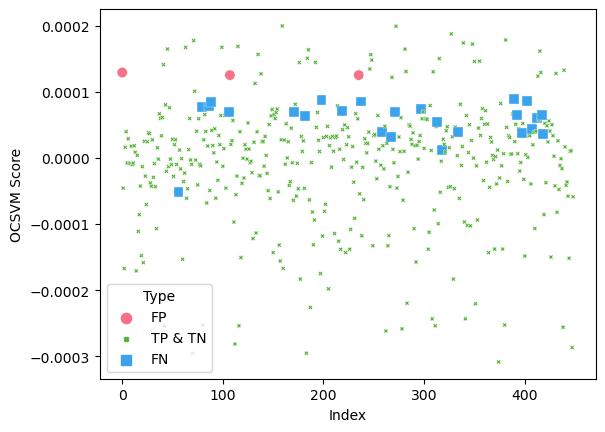

In [24]:
sns.scatterplot(data=df, x=df.index, y='y_scores', hue='Type', palette='husl', style='Type', size='Type', size_order=['TP & TN', 'FP', 'FN'], sizes=(100,10))

plt.xlabel("Index")
plt.ylabel("OCSVM Score")

Text(0, 0.5, 'OCSVM Score')

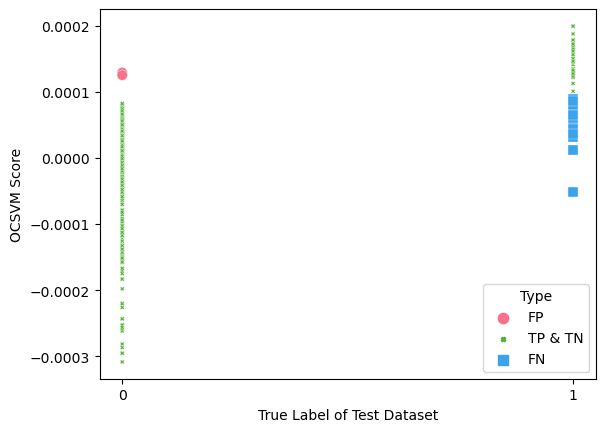

In [25]:
sns.scatterplot(data=df, x=df['y_test'].astype(str), y='y_scores', hue='Type', palette='husl', style='Type', size='Type', size_order=['TP & TN', 'FP', 'FN'], sizes=(100,10))

plt.xlabel("True Label of Test Dataset")
plt.ylabel("OCSVM Score")

Text(0, 0.5, 'OCSVM Score')

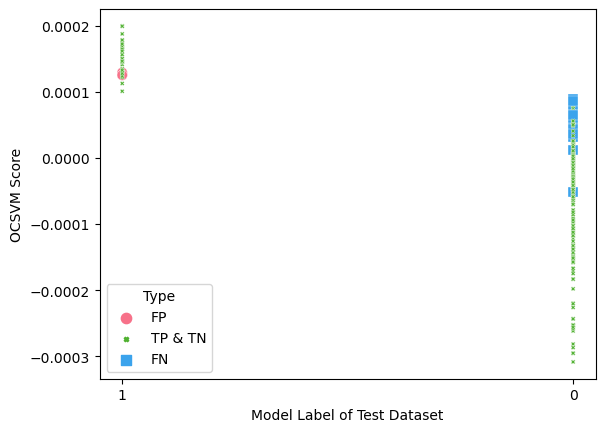

In [26]:
# Shows FN are clustered at lower end of the scoring, so scoring can be used to rank
# FP doesn't matter
sns.scatterplot(data=df, x=df['y_pred'].astype(str), y='y_scores', hue='Type', palette='husl', style='Type', size='Type', size_order=['TP & TN', 'FP', 'FN'], sizes=(100,10))

plt.xlabel("Model Label of Test Dataset")
plt.ylabel("OCSVM Score")

This anomaly detection model will can monitor new loitering events generated by GFW. New loitering events will be inferred and when anomalies are registered, they can be ranked using the OCSVM score. Higher ranking OCSVM scores correspond to a higher likelihood of the vessel engaging in IUU activities. **We see from the Model Labels that False Negative scores (non-IUU events classified as IUU event) lie close to the decision boundary; thus, ranking anomalies by their score remains a valid tactic to prioritize inspection of vessels by the appropriate authorities, as well as minimizing incorrect allocation of inspection resources**. Ranking in this manner will reduce the chance of inspecting a legal vessel; this was made possible by weighing Recall more during model training.

Conversely, False Positives (IUU events classified as non-IUU events) scoring cannot be ranked. However, this is not necessary as there are no action-items for an in-class event. These IUU events will be missed – an unfortunate reality of modelling.

In [27]:
# Feature Importance
a,b,c,d = model.feature_importances_
print("Importance Scores:")
print(f"Loitering Start Hour: {round(a*100,4)}%")
print(f"Loitering Total Hours: {round(b*100,4)}%")
print(f"Average Speed (knots): {round(c*100,4)}%")
print(f"Average Distance from Shore (nautical miles): {round(d*100,4)}%")

Importance Scores:
Loitering Start Hour: 12.0359%
Loitering Total Hours: 10.8072%
Average Speed (knots): 4.4672%
Average Distance from Shore (nautical miles): 72.6897%


## 5) Conclusions and Next Steps

The analysis of the loitering event dataset was able to determine a decision boundary that classified the loitering event as IUU activity or non-IUU activity. By using a supervised model trained on labeled data, the larger unlabeled dataset was pseudo-labeled to develop a robust anomaly detection model. This model can correctly classify the loitering events with up to 86% accuracy, as well as provide a ranking method that can be utilized by the end users to efficiently plan their inspection activities. Furthermore, the analysis also determined that distance from shore is the biggest indicator of an IUU event, followed by how long the loitering event takes place. These two features account for about 84% of the information contained in the features analyzed. The figure below provides a visual summary of the loitering events as classified by the model.

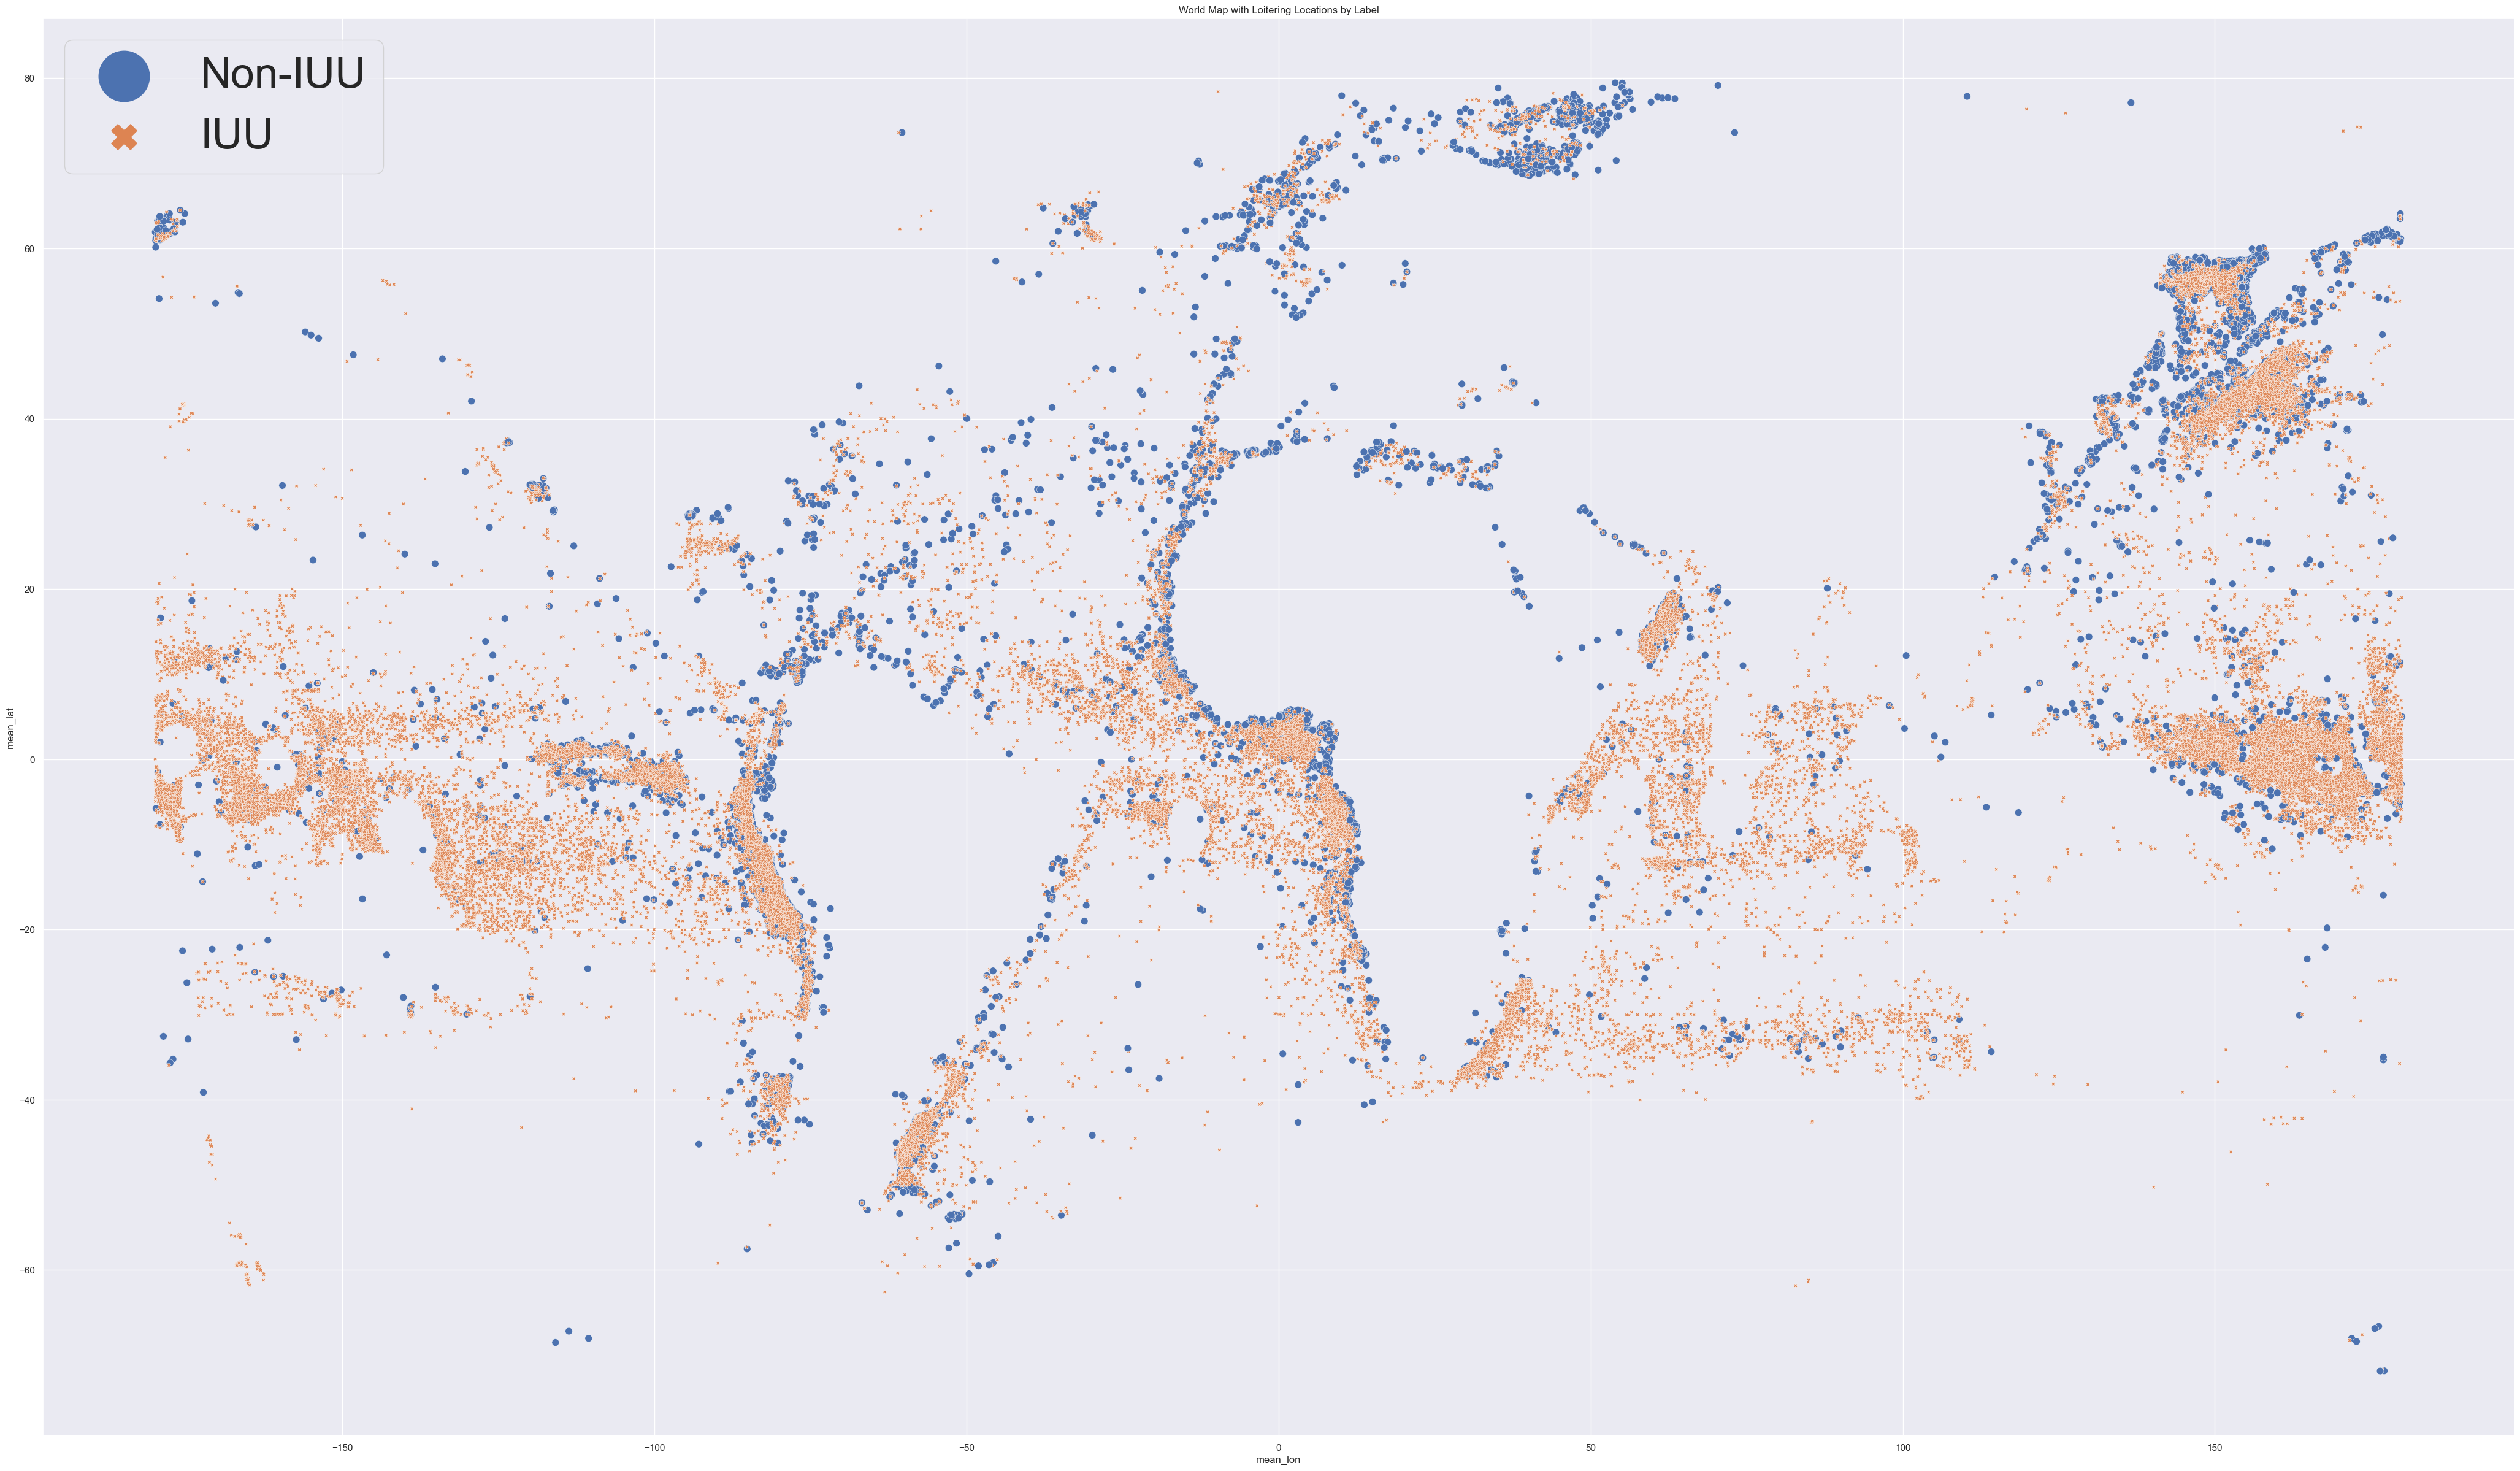

In [33]:
from matplotlib.legend_handler import HandlerPathCollection

x = np.concatenate([final_scaler.inverse_transform(final_dataset[:,:-1]),final_dataset[:,-1][:,None]], axis=1)
df_end = pd.DataFrame(x, columns=['loitering_start_hour', 'loitering_hours', 'avg_speed_knots','avg_distance_from_shore_nm','response'])

y = df_loiter_data.merge(df_end, how='inner', on=['loitering_hours', 'avg_speed_knots','avg_distance_from_shore_nm'])
y = y.rename(columns={'response_y':"Label"})
y['Label'] = y['Label'].apply(lambda x: "IUU" if x==0 else 'Non-IUU')

sc = sns.scatterplot(data=y, x="mean_lon",y="mean_lat", hue='Label', size='Label', style='Label')
plt.title('World Map with Loitering Locations by Label')

plt.legend(fontsize=50, markerscale=7)
plt.show()

For the next steps in this analysis, Global Fishing Watch can be contacted to determine if there is any unpublished data available internally that can be used to further strengthen this analysis, such as more labeled data or additional features that could be added. Going further, the model can be deployed for practical use; the results from any action taken because of the model’s output should be used to further train and strengthen the model.

Even on the nearly unmonitored ocean where human activities can largely go unnoticed, the use of such data analyses is crucial to identify and prosecute vessels engaged in illegal activities that harm the delicate ecosystem, violate human rights, and nullify the efforts of law-abiding fishing organizations.

## 6) References

[1] I. Global Industry Analysts, "Research and Markets," October 2022. [Online]. Available: https://www.researchandmarkets.com/reports/338675/seafood_global_market_trajectory_and_analytics.

[2] N. FIsheries, "Understanding Illegal, Unreported, and Unregulated Fishing," [Online]. Available: https://www.fisheries.noaa.gov/insight/understanding-illegal-unreported-and-unregulated-fishing. [Accessed 25 October 2022].

[3] G. F. Watch, "Revealing the Supply Chain at Sea: A Global Analysis of Transshipment and Bunker Vessels," Global Fishing Watch, April 2021.

[4] R. M. Saito T, "The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets," PLoS ONE, no. 10(3): e0118432.doi:10.1371/journal.pone.0118432, 2015.

Key Links

* https://www.fisheries.noaa.gov/insight/understanding-illegal-unreported-and-unregulated-fishing

* https://globalfishingwatch.org/data-download/datasets/public-fishing-effort

* https://www.science.org/doi/10.1126/science.aao5646